# Survival Analysis 

This notebook tests survival risk for a driver mutation. This survival analysis includes: Kaplan Meier plot, Multivariate Survival Risk plot, and the Cox's Proportional Hazard Test. 

Imports

In [1]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [3]:
#import warnings
#warnings.filterwarnings('ignore')

In [104]:
def get_survival_cols(cancer_object):
    cancer = cancer_object.get_cancer_type()
    #print(cancer)
    
    # get unique survival col names
    if cancer == 'gbm':
        cols = ['vital_status', 'path_diag_to_last_contact_days', 'path_diag_to_death_days']
    if cancer == 'hnscc':
        cols = ['follow_up_vital_status', 'follow_up_days']
        #cols = ['VITAL_STATUS', 'PATHO_DIAG_TO_LAST_CONT_DAYS', 'PATHO_DIAG_TO_DEATH_DAYS'] # followup cols
    if cancer == 'luad':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    if cancer == 'ovarian':
        cols = ['Vital_Status', 'Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
    if cancer == 'endometrial':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    
    # lscc no follow up or clin matching survival cols
    
    # csv contains days_between_last_contact_or_death
    if cancer == 'brca':
        cols = ['Vital Status (at time of last contact)'] 
    if cancer == 'colon':
        cols = ['Vital Status (at time of last contact)'] 

    return cols

In [3]:
def get_most_recent_last_contact_df(survival_in):
    d = {}
    df = survival_in[['days_to_last_contact']]
    index_list = list(df.index.unique())
    for i in index_list:
        one_index_df = df.loc[[i]]
        # Get the latest number when duplicate records
        most_recent = one_index_df['days_to_last_contact'].max() # get most recent (highest num)
        d[i] = most_recent
        
    last_contact_df = pd.DataFrame.from_dict(d, orient='index', columns=['days_to_last_contact'])
    last_contact_df.index.name = 'Patient_ID'
    
    return last_contact_df   

# Step 1: Import cancer data

In [4]:
g = cptac.Gbm()
o = cptac.Ovarian()
col = cptac.Colon()
b = cptac.Brca()
l = cptac.Luad()
hn = cptac.Hnscc()
ls = cptac.Lscc()
en = cptac.Endometrial()
#kidney = cptac.Ccrcc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 7)


# Step 2: Get df with driver status and survival data

Import a dataframe for the the driver you are interested in. The index should be the Patient_ID and the first column should contain if the patient has the driver.

In [38]:
# Get driver status
has_driver = pd.read_csv('has_driver_PTEN/GBM_has_driver.csv', index_col=0)

# Get survival data: vital_status, days_to_last_contact, days_to_death
cols = get_survival_cols(g) 
clin = g.get_clinical(tissue_type = 'tumor')
df = clin[cols]
survival_df = df.rename(columns = {cols[0]: 'vital_status', cols[1]: 'days_to_last_contact', cols[2]: 'days_to_death'})
survival_df = survival_df.dropna(subset = ['vital_status']) # keep samples with survival data

# merge driver status with survival 
mut_survival = survival_df.join(has_driver, on = 'Patient_ID', how = 'left') 

In [42]:
# Drop row with NaN in vital status (before replacing with boolean)
mut_survival = mut_survival[mut_survival['vital_status'].notna()]
mut_survival = mut_survival[mut_survival['has_driver'].notna()]
print(mut_survival.vital_status.value_counts(),'\n')
print('total samples with vital_status and has_diver data:', len(mut_survival), '\n')

Deceased    47
Living      44
Name: vital_status, dtype: int64 

total samples with vital_status and has_diver data: 91 



Prepare the df for plotting: change vital status to boolean values, combine days_to_last_contact and days_to_death into one column, and change has_driver to int values.

In [43]:
#Make the vital_status column boolean
mut_survival['vital_status'] = mut_survival['vital_status'].replace('Living', False)
mut_survival['vital_status'] = mut_survival['vital_status'].replace('Deceased', True)
mut_survival['vital_status'] = mut_survival['vital_status'].astype('bool')
print(mut_survival['vital_status'].value_counts())

True     47
False    44
Name: vital_status, dtype: int64


In [44]:
# Create one column with days between last contact or death
days = ['days_to_last_contact', 'days_to_death']
survival = mut_survival.assign(days_to_last_contact_or_death = mut_survival[days].sum(1)).drop(days, 1)

In [45]:
# map numeric values to correspond with mutation status
mutation_map = {False : 0, True : 1}

survival['has_driver'] = survival['has_driver'].map(mutation_map)

#Then we will drop missing values, as missing values 
#will throw an error in the functions we will use in lifelines.
df_clean = survival.dropna(axis=0, how='any').copy()
df_clean

,vital_status,has_driver,days_to_last_contact_or_death
Patient_ID,,,
C3L-00104,True,1,257.0
C3L-00365,True,1,602.0
C3L-00674,True,1,863.0
C3L-00677,True,1,308.0
C3L-01040,False,1,608.0
...,...,...,...
C3N-03088,True,0,168.0
C3N-03182,False,1,501.0
C3N-03183,True,1,628.0


Verify that your columns are the correct data types.  The event of interest, in this case vital_status, needs to contain boolean values and all other columns in the table must be of a numeric type (either int64 or float64).

In [58]:
# check that columns are the right types
for e in survival.columns:
    print(e, ":", survival[e].dtype)

vital_status : bool
has_driver : int64
days_to_last_contact_or_death : float64


# Step 3: Kaplan Meier Plotting

Kaplan Meier plots show the probability of some event occuring over a given length of time, based on some attribute(s). 

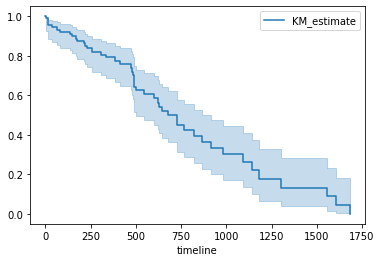

In [47]:
# Plot
time = survival['days_to_last_contact_or_death']
status = survival['vital_status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Plot Multivariate Survival Risk

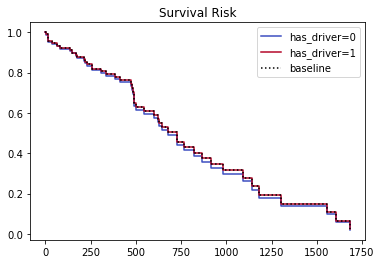

In [48]:
cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")

plot_title = "Survival Risk"
cph.plot_partial_effects_on_outcome('has_driver', [0,1], cmap='coolwarm', title=plot_title)
    

In [49]:
cph.print_summary(model="untransformed variables", decimals=3)


<lifelines.CoxPHFitter: fitted with 91 total observations, 44 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 91
number of events observed = 47
   partial log-likelihood = -158.735
         time fit was run = 2020-11-14 00:44:28 UTC
                    model = untransformed variables

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
has_driver -0.047      0.954      0.417           -0.864            0.769                0.422                2.158

                z     p   -log2(p)
covariate                         
has_driver -0.114 0.909      0.137
---
Concordance = 0.498
Partial AIC = 319.470
log-likelihood ratio test = 0.013 on 1 df
-log2(p) of ll-ratio test = 0.136

# Step 6: Cox's Proportional Hazard Test

With the proportional_hazard_test function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival. This is shown by the hazard ratio in the column labeled -log2(p) below. In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival. A ratio less than 1 suggests that an attribute contributes to lower survival risk. A ratio greater than 1 suggests that an attribute contributes to higher survival risk.

In [50]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 91 total observations, 44 right-censored observations>
         test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
has_driver            0.16 0.69      0.54

Below, we show the confidence interval for the hazard ratio. 

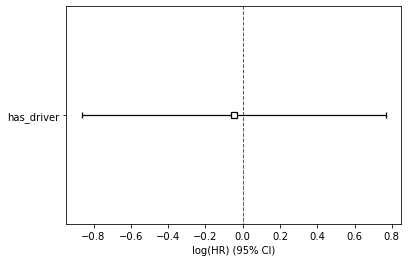

In [77]:
cph.plot()